# Set-Up

In [56]:
!pip3 install datasets
!pip install accelerate -U

import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, RandomHorizontalFlip, RandomRotation, ColorJitter, Resize
import transformers
from transformers import AutoImageProcessor, DefaultDataCollator, AutoModelForImageClassification, BeitForImageClassification, Trainer, TrainingArguments, EarlyStoppingCallback, ResNetForImageClassification
from datasets import load_dataset, load_metric, DatasetDict
from PIL import Image
import accelerate
import torch
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, balanced_accuracy_score
import datasets

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


# Importar datos

In [3]:
!unzip "/content/drive/MyDrive/Colab Notebooks/archive.zip" -d "/kaggle"

Streaming output truncated to the last 5000 lines.
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: /kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: /kaggle/Alzhe

# Cargar datos

In [51]:
checkpoint = "microsoft/resnet-50"

dataset = load_dataset("imagefolder", data_dir="/kaggle/Alzheimer_s Dataset")

labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

print(labels)

Resolving data files:   0%|          | 0/5121 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1279 [00:00<?, ?it/s]

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


# Visualizar los datos

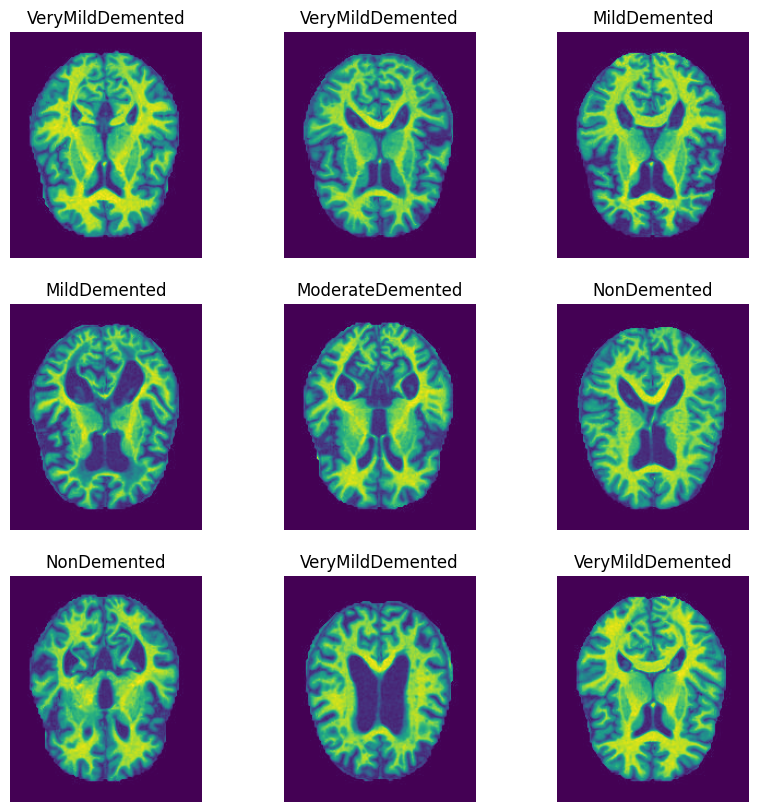

In [52]:
plt.figure(figsize=(10, 10))
for i in range(9):
    index = random.randint(0, len(dataset["train"]) - 1)
    ax = plt.subplot(3, 3, i + 1)
    img = dataset["train"][index]["image"]
    label = id2label[str(dataset["train"][index]["label"])]
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.show()

# Preprocesamiento de los datos

In [77]:
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

def process_example(example):
    inputs = image_processor(example['image'], return_tensors='pt')
    inputs['labels'] = example['label']
    return inputs

def transform(example_batch):
    images = [img.convert("RGB") if img.mode != "RGB" else img for img in example_batch['image']]
    inputs = image_processor(images, return_tensors='pt')
    inputs['labels'] = example_batch['label']

    return inputs

proc_dataset = dataset.with_transform(transform)

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

print(image_processor)

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}



# Data Augmentation

In [78]:
augmentation_transforms = Compose([
    Resize(size=(224,224)),
    RandomRotation(degrees=45),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    ToTensor()
])

normal_transforms = Compose([
    Resize(size=(224,224)),
    ToTensor()
])

def transform(example_batch, is_aug=True):
    if is_aug:
        images = [augmentation_transforms(img.convert("RGB")) for img in example_batch['image']]
    else:
        images = [normal_transforms(img.convert("RGB")) for img in example_batch['image']]

    inputs = {
        'pixel_values': torch.stack(images),  # Stack images into a single tensor
        'labels': example_batch['label']  # Labels stay the same
    }
    return inputs

new_transforms = Compose([
    ToTensor(),
])

def new_transform(example_batch):
    images = [new_transforms(img.convert("RGB")) for img in example_batch['image']]

    inputs = {
        'pixel_values': torch.stack(images),  # Stack images into a single tensor
        'labels': example_batch['label']  # Labels stay the same
    }
    return inputs

normal_train_dataset = dataset.with_transform(lambda batch: transform(batch, is_aug=False))

aug_train_dataset = dataset.with_transform(lambda batch: transform(batch, is_aug=True))

<class 'datasets.arrow_dataset.Dataset'>
10242
{'pixel_values': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, 

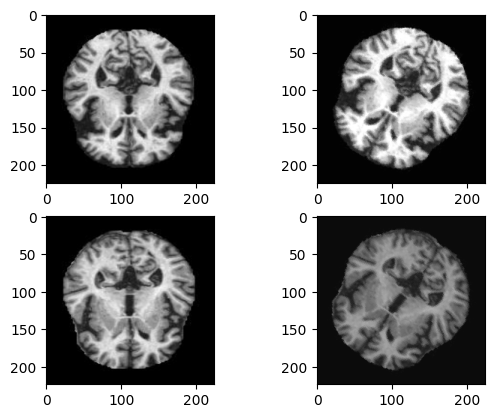

In [79]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(normal_train_dataset['train'][11]['pixel_values'].permute(1, 2, 0))
axarr[0,1].imshow(aug_train_dataset['train'][11]['pixel_values'].permute(1, 2, 0))
axarr[1,0].imshow(normal_train_dataset['train'][21]['pixel_values'].permute(1, 2, 0))
axarr[1,1].imshow(aug_train_dataset['train'][21]['pixel_values'].permute(1, 2, 0))

print(type(dataset['train']))

combined_train_dataset = DatasetDict({"train": datasets.concatenate_datasets([normal_train_dataset["train"], aug_train_dataset["train"]])})
combined_test_dataset = DatasetDict({"test": datasets.concatenate_datasets([normal_train_dataset["test"], aug_train_dataset["test"]])})

combined_dataset = DatasetDict({
    'train': combined_train_dataset['train'],
    'test': combined_test_dataset['test']
})

combined_dataset = combined_dataset.shuffle(seed=42)
new_dataset = combined_dataset.with_transform(lambda batch: new_transform(batch))

# Modelo

In [86]:
model = ResNetForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

model = model.to(device)

def compute_metrics(p):
    logits, labels = p
    pred = np.argmax(logits, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred, average='weighted')
    #roc_auc = roc_auc_score(y_true=labels, y_score=logits, average='macro', multi_class='ovr')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

early_stopper = EarlyStoppingCallback(
    early_stopping_patience=5,
    early_stopping_threshold=0.05)

training_args = TrainingArguments(
    output_dir="/home/results",
    learning_rate=0.002,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    seed=42,
    gradient_accumulation_steps=4,
    eval_strategy="epoch",
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    logging_dir='/home/logs',
    logging_steps=10,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_strategy="epoch",
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.002,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0.6,
    #amsgrad=True
)

from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.2,
    patience=2,
    threshold=0.01,
    min_lr=1e-8
)

trainer = Trainer(
    model=model,
    args=training_args,
    #data_collator=collate_fn,
    train_dataset=new_dataset["train"],
    eval_dataset=new_dataset['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    callbacks=[early_stopper],
    optimizers=(optimizer, scheduler)
)

history = trainer.train()
print(history)
trainer.evaluate(eval_dataset=new_dataset['test'])

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([4, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,0.320400,1.792813,0.608288,0.690731,0.608288,0.546470
1,0.127800,0.844493,0.677091,0.688395,0.677091,0.681581
2,0.099100,2.262285,0.564504,0.707105,0.564504,0.465641
4,0.069200,0.978295,0.690383,0.716897,0.690383,0.670451
5,0.002800,0.780544,0.746677,0.757130,0.746677,0.741889
6,0.001200,0.706623,0.757623,0.758436,0.757623,0.756061
8,0.000900,0.681687,0.780297,0.784471,0.780297,0.781576
9,0.000500,0.694987,0.780297,0.787908,0.780297,0.782027
10,0.000700,0.747571,0.767005,0.782128,0.767005,0.770787
12,0.001800,0.775422,0.740422,0.760002,0.740422,0.743939


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=1923, training_loss=0.09264280692685359, metrics={'train_runtime': 1176.3585, 'train_samples_per_second': 174.131, 'train_steps_per_second': 2.72, 'total_flos': 1.9045053089925857e+18, 'train_loss': 0.09264280692685359, 'epoch': 12.0})


{'eval_loss': 0.6816871762275696,
 'eval_accuracy': 0.7802971071149335,
 'eval_precision': 0.7844714059305734,
 'eval_recall': 0.7802971071149335,
 'eval_f1': 0.7815760080900885,
 'eval_runtime': 8.3828,
 'eval_samples_per_second': 305.148,
 'eval_steps_per_second': 19.087,
 'epoch': 12.0}